# Occlusion Heat Maps

In [1]:
from torchvision import transforms
from torchvision.models import vgg16, resnet152, alexnet
import torch

import os
import json
from PIL import Image
import numpy as np

In [2]:
labels = json.load(open('./data/imagenet/ILSVRC/Data/CLS-LOC/val_10p/imagnet_classes.json'))

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [4]:
model = alexnet(pretrained = True)
model.eval()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [75]:
image_name = 'ILSVRC2012_val_00001172.JPEG'
# i1 = './data/imagenet/ILSVRC/Data/CLS-LOC/val_10p/images/'+image_name
i1 = './streamLitHelp/images/horizontal/' + image_name
l1 = int(labels[image_name.split('.')[0]])



In [76]:
print(i1, l1)

./streamLitHelp/images/horizontal/ILSVRC2012_val_00001172.JPEG 269


In [77]:
preprocessing1 = transforms.Compose([
    transforms.Resize((224, 224)),
])

preprocessing2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])

preprocessing = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])

img = Image.open(i1).convert('RGB')
img = preprocessing(img).unsqueeze(dim = 0)
img = img.to(device)
print(img.shape)

torch.Size([1, 3, 224, 224])


In [78]:
torch.argmax(model(img)).numpy(), l1, 

(array(272), 269)

In [79]:
realPred = int(model(img)[0][l1].data.numpy())
occSize = 16
preds = np.zeros((224, 224))
img = Image.open(i1).convert('RGB')
img = np.array(preprocessing1(img))
print(img.shape)
for i in range(0, 224, occSize):
    for j in range(0, 224, occSize):
        img1 = np.array(img)
        img1[i:i+occSize, j:j+occSize, :] = 0
        img1 = Image.fromarray(img1)
        img1 = preprocessing2(img1).unsqueeze(dim = 0).to(device)
        pred = model(img1)
        pred = -realPred+pred[0][l1].detach()
        preds[i:i+occSize, j:j+occSize] = pred
        
preds = 255.*(preds-np.min(preds))/(np.max(preds)-np.min(preds))

(224, 224, 3)


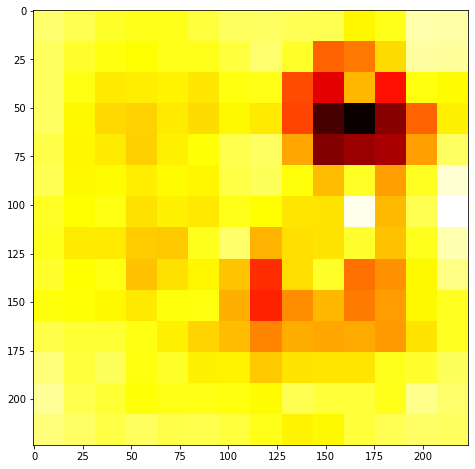

In [80]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(preds, cmap='hot', interpolation='nearest')
plt.show()

In [81]:
import cv2
map_img = np.uint8(preds)
heatmap_img = cv2.applyColorMap(map_img, cv2.COLORMAP_JET)

In [82]:
fin = cv2.addWeighted(heatmap_img, 0.4, img, 0.6, 0)

(224, 224, 3)


(-0.5, 223.5, 223.5, -0.5)

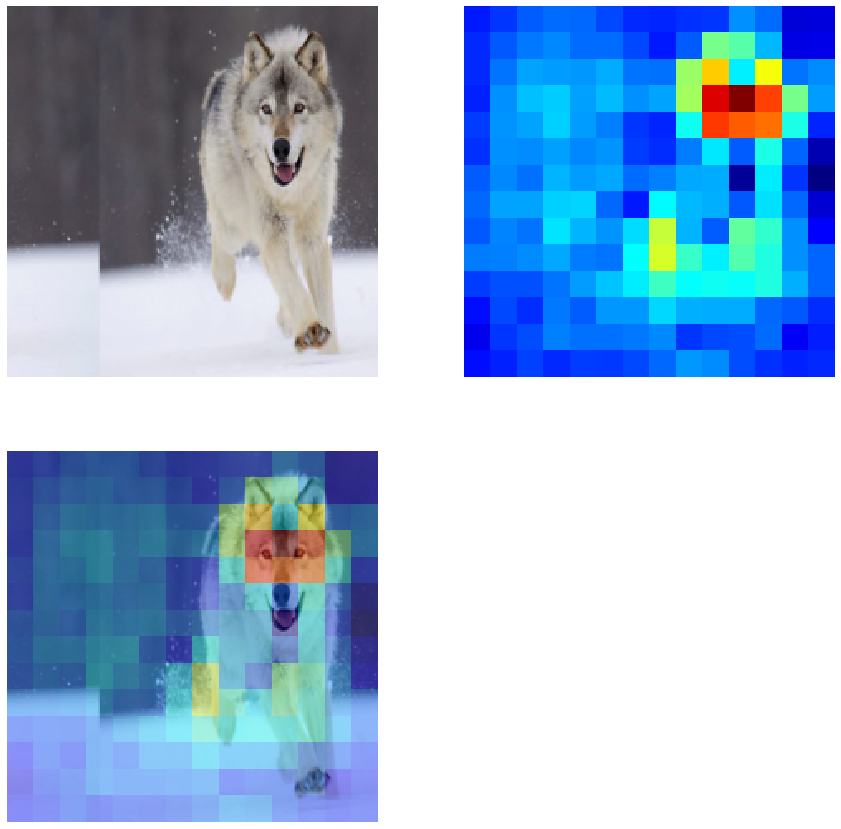

In [83]:
print(img.shape)
fig, axs = plt.subplots(2, 2, figsize=(15,15))
axs[0, 0].imshow(img)
axs[0, 1].imshow(heatmap_img, alpha = 1., cmap = plt.cm.jet)
axs[1, 0].imshow(fin, alpha = 1., cmap = plt.cm.jet)
axs[1, 1].remove()
axs[0, 0].axis('off')
axs[0, 1].axis('off')
axs[1, 0].axis('off')

In [84]:
image_name = image_name.split('.')[0]
fig, axs = plt.subplots(1, 1, figsize=(10,10))
axs.imshow(img)
axs.axis('off')
plt.savefig('./visualizations/shuffle/'+image_name+'.jpg')
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(10,10))
axs.imshow(fin, alpha = 1., cmap = plt.cm.jet)
axs.axis('off')
plt.savefig('./visualizations/horizontal/'+image_name+'_occlusion.jpg')
plt.clf()

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

# GradCAM

In [85]:
import torch
from torch.autograd import Function as TorchFunc
import numpy as np
from PIL import Image


import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import vgg16, resnet152, alexnet
from torchvision import transforms

import os
import json
from PIL import Image
import numpy as np
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [86]:
class CustomReLU(TorchFunc):
    """
    Define the custom change to the standard ReLU function necessary to perform guided backpropagation.
    We have already implemented the forward pass for you, as this is the same as a normal ReLU function.
    """

    @staticmethod
    def forward(self, x):
        output = torch.addcmul(torch.zeros(x.size()), x, (x > 0).type_as(x))
        self.save_for_backward(x, output)
        return output

    @staticmethod
    def backward(self, y):
        ##############################################################################
        # TODO: Implement this function. Perform a backwards pass as described in    #
        # the guided backprop paper ( there is also a brief description at the top   #
        # of this page).                                                             #
        # Note: torch.addcmul might be useful, and you can access  the input/output  #
        # from the forward pass with self.saved_tensors.                             #
        ##############################################################################
        x, output = self.saved_tensors
        mask = (x == output) * 1.0
        dx = mask * y
        dx = torch.addcmul(torch.zeros(dx.size()), dx, (dx > 0).type_as(dx))
        return dx
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

        
class GradCam:
    def guided_backprop(self, X_tensor, y_tensor, gc_model):
        """
        Compute a guided backprop visualization using gc_model for images X_tensor and 
        labels y_tensor.

        Input:
        - X_tensor: Input images; Tensor of shape (N, 3, H, W)
        - y: Labels for X; LongTensor of shape (N,)
        - model: A pretrained CNN that will be used to compute the guided backprop.

        Returns:
        - guided backprop: A numpy array of shape (N, H, W, 3) giving the guided backprop for 
        the input images.
        """

        # Thanks to Farrukh Rahman (Fall 2020) for pointing out that Squeezenet has
        #  some of it's ReLU modules as submodules of 'Fire' modules
        #  
        for param in gc_model.parameters():
            param.requires_grad = True

        for idx, module in gc_model.features._modules.items():
            if module.__class__.__name__ == 'ReLU':
                gc_model.features._modules[idx] = CustomReLU.apply
            elif module.__class__.__name__ == 'Fire':
                for idx_c, child in gc_model.features[int(idx)].named_children():
                    if child.__class__.__name__ == 'ReLU':
                        gc_model.features[int(idx)]._modules[idx_c] = CustomReLU.apply
        ##############################################################################
        # TODO: Implement guided backprop as described in paper.                     #
        # (Hint): Now that you have implemented the custom ReLU function, this       #
        # method will be similar to a single training iteration.                     #
        #                                                                            #
        # Also note that the output of this function is a numpy.                     #
        ##############################################################################
        output = gc_model(X_tensor)
        output = torch.sum(torch.stack([output[i][y_tensor[i]] for i in range(len(y_tensor))]))
        output.backward()
        return X_tensor.grad.data.cpu().numpy().transpose(0, 2, 3, 1)
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

    def grad_cam(self, X_tensor, y_tensor, gc_model):
        """
        Input:
        - X_tensor: Input images; Tensor of shape (N, 3, H, W)
        - y: Labels for X; LongTensor of shape (N,)
        - model: A pretrained CNN that will be used to compute the gradcam.
        """
        conv_module = gc_model.features[12]
        self.gradient_value = None  # Stores gradient of the module you chose above during a backwards pass.
        self.activation_value = None  # Stores the activation of the module you chose above during a forwards pass.

        def gradient_hook(a, b, gradient):
            self.gradient_value = gradient[0]

        def activation_hook(a, b, activation):
            self.activation_value = activation

        conv_module.register_forward_hook(activation_hook)
        conv_module.register_backward_hook(gradient_hook)
        ##############################################################################
        # TODO: Implement GradCam as described in paper.                             #
        #                                                                            #
        # Compute a gradcam visualization using gc_model and convolution layer as    #
        # conv_module for images X_tensor and labels y_tensor.                       #
        #                                                                            #
        # Return:                                                                    #
        # If the activation map of the convolution layer we are using is (K, K) ,    #
        # student code should end with assigning a numpy array of shape (N, K, K) to #
        # a variable 'cam'. Instructor code would then take care of rescaling it     #
        # back                                                                       #
        ##############################################################################
        N = X_tensor.shape[0]
        output = gc_model(X_tensor)
        loss = torch.sum(torch.stack([output[i][y_tensor[i]] for i in range(N)]))
        loss.backward()
        pooled_gradients = torch.mean(self.gradient_value, dim = [2, 3])
        activations = self.activation_value.detach()
        for i in range(N):
            for j in range(activations.shape[0]):
                activations[i, j, :, :] *= pooled_gradients[i][j]
        cam = torch.mean(activations, dim=1).cpu().numpy()
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

        # Rescale GradCam output to fit image.
        cam_scaled = []
        for i in range(cam.shape[0]):
            cam_scaled.append(np.array(Image.fromarray(cam[i]).resize(X_tensor[i, 0, :, :].shape, Image.BICUBIC)))
        cam = np.array(cam_scaled)
        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam
    
def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


In [87]:
def preprocess(img, size=224):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        transforms.Lambda(lambda x: x[None]),
    ])
    return transform(img)

In [88]:
model.avgpool

AdaptiveAvgPool2d(output_size=(6, 6))

torch.Size([1, 3, 224, 224]) torch.Size([1])


<Figure size 720x720 with 0 Axes>

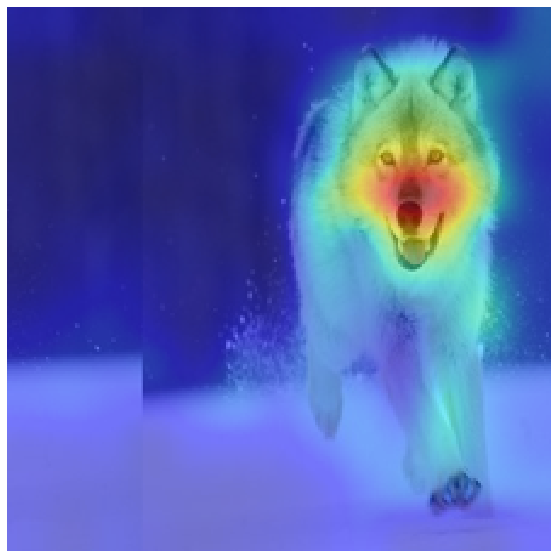

In [93]:
image_name = 'ILSVRC2012_val_00001172.JPEG'
# i1 = './data/imagenet/ILSVRC/Data/CLS-LOC/val_10p/images/'+image_name
i1 = './streamLitHelp/images/horizontal//' + image_name
l1 = int(labels[image_name.split('.')[0]])

img = Image.open(i1).resize((224, 224))
X = np.expand_dims(np.array(img), axis = 0)
y = np.array([int(labels[image_name.split('.')[0]])])
class_names = json.load(open('./class_names.json'))

# FOR THIS SECTION ONLY, we need to use gradients. We introduce a new model we will use explicitly for GradCAM for this.
gc_model = alexnet(pretrained=True)
gc = GradCam()

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0).requires_grad_(True)
y_tensor = torch.LongTensor(y)
print(X_tensor.shape, y_tensor.shape)

# Guided Back-Propagation
gbp_result = gc.guided_backprop(X_tensor,y_tensor, gc_model)

# plt.figure(figsize=(24, 24))
# for i in range(gbp_result.shape[0]):
#     plt.subplot(1, 5, i + 1)
#     img = gbp_result[i]
#     img = rescale(img)
#     plt.imshow(img)
#     plt.title(class_names[str(y[i])])
#     plt.axis('off')
# plt.gcf().tight_layout()
# plt.savefig('./guided_backprop.png')



# GradCam
# GradCAM. We have given you which module(=layer) that we need to capture gradients from, which you can see in conv_module variable below
gc_model = torchvision.models.squeezenet1_1(pretrained=True)
for param in gc_model.parameters():
    param.requires_grad = True

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0).requires_grad_(True)
y_tensor = torch.LongTensor(y)
gradcam_result = gc.grad_cam(X_tensor, y_tensor, gc_model)

plt.figure(figsize=(10, 10))
image_name = image_name.split('.')[0]
fig, axs = plt.subplots(1, 1, figsize=(10,10))
gradcam_val = gradcam_result[0]
img = X[0] + (matplotlib.cm.jet(gradcam_val)[:,:,:3]*255)
img = img / np.max(img)
axs.imshow(img)
axs.axis('off')
plt.savefig('./visualizations/horizontal/'+image_name+'_gradcam.jpg')
# for i in range(gradcam_result.shape[0]):
#     gradcam_val = gradcam_result[i]
#     img = X[i] + (matplotlib.cm.jet(gradcam_val)[:,:,:3]*255)
#     img = img / np.max(img)
#     plt.subplot(1, 5, i + 1)
#     plt.imshow(img)
#     plt.title(class_names[str(y[i])])
#     plt.axis('off')
# plt.gcf().tight_layout()
# image_name = image_name.split('.')[0]
# plt.savefig('./visualizations/original/'+image_name+'_gradcam.png')